# Encoder And Decoder Model

# 0. GPU测试

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/Users/yanqiang/PycharmProjects/kaikeba/lecture_5_2')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from utils.data_loader import build_dataset,load_dataset,preprocess_sentence,load_test_dataset
from utils.wv_loader import load_embedding_matrix,load_vocab
from utils.config import *
from gensim.models.word2vec import LineSentence, Word2Vec
from utils.gpu_utils import config_gpu
config_gpu()

Building prefix dict from the default dictionary ...
2020-02-09 16:25:51,680 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/cb/hnw705xd7277l6s881fs2jgm0000gp/T/jieba.cache
2020-02-09 16:25:51,688 : DEBUG : Loading model from cache /var/folders/cb/hnw705xd7277l6s881fs2jgm0000gp/T/jieba.cache
Loading model cost 1.621 seconds.
2020-02-09 16:25:53,308 : DEBUG : Loading model cost 1.621 seconds.
Prefix dict has been built successfully.
2020-02-09 16:25:53,320 : DEBUG : Prefix dict has been built successfully.


In [ ]:
# GPU：RTX 2080 40min-1小时
# CPU：2个小时

In [12]:
import tensorflow as tf
from utils.plot_utils import plot_attention
from tqdm import tqdm
import time
from seq2seq_tf2.batcher import train_batch_generator

# 0. 预处理数据

In [3]:
%%time
# build_dataset(train_data_path,test_data_path)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


# 1. 加载数据

## 1.1 加载vocab

In [9]:
vocab,reverse_vocab=load_vocab(vocab_path)

## 1.2 加载数据集

In [ ]:
params = {}
params["vocab_size"] = len(vocab)
params["embed_size"] = 500
params["enc_units"] = 512
params["attn_units"] = 512
params["dec_units"] = 512

params["batch_size"] = 64 # 16 32 64 128

params["epochs"] = 5

params["max_enc_len"] = 200
params["max_dec_len"] = 41

params["embedding_dim"] = 500

In [ ]:
dataset, steps_per_epoch = train_batch_generator(batch_size=64,
                                                 max_enc_len=params["max_enc_len"],
                                                 max_dec_len=params["max_dec_len"])
test_X = load_test_dataset(params["max_dec_len"])

## 1.3 加载预训练权重

In [47]:
embedding_matrix=load_embedding_matrix()

# 2. 模型训练

## 2.1 基本参数设置

In [48]:
params = {}
params["vocab_size"] = len(vocab)
params["embed_size"] = 500
params["enc_units"] = units
params["attn_units"] = units
params["dec_units"] = units
params["batch_size"] = 64
params["epochs"] = 5
params["max_enc_len"] = 200
params["max_dec_len"] = 41

## 2.2 构建Encoder

In [49]:
from seq2seq_tf2.seq2seq_model import Seq2Seq

In [50]:
model=Seq2Seq(params)

# 2 读取训练好的模型

In [51]:
from utils.config import checkpoint_dir,checkpoint_prefix

In [52]:
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

In [53]:
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


# 3. 训练

In [54]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


pad_index=vocab['<PAD>']
nuk_index=vocab['<UNK>']

def loss_function(real, pred):
    pad_mask = tf.math.equal(real, pad_index)
    nuk_mask = tf.math.equal(real, nuk_index)
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,nuk_mask))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [55]:
@tf.function
def train_step(inp, targ):
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        
        batch_loss = loss_function(targ[:, 1:], predictions)

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [ ]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in range(epochs):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7875
Epoch 1 Batch 1 Loss 1.7876
Epoch 1 Batch 2 Loss 1.7762
Epoch 1 Batch 3 Loss 1.9339
Epoch 1 Batch 4 Loss 1.8832
Epoch 1 Batch 5 Loss 1.8522
Epoch 1 Batch 6 Loss 1.6765
Epoch 1 Batch 7 Loss 2.0191
Epoch 1 Batch 8 Loss 1.7543
Epoch 1 Batch 9 Loss 1.9231
Epoch 1 Batch 10 Loss 1.5854
Epoch 1 Batch 11 Loss 1.6374
Epoch 1 Batch 12 Loss 1.9204
Epoch 1 Batch 13 Loss 1.8724
Epoch 1 Batch 14 Loss 1.5321
Epoch 1 Batch 15 Loss 1.7678
Epoch 1 Batch 16 Loss 1.7474
Epoch 1 Batch 17 Loss 1.5806
Epoch 1 Batch 18 Loss 1.5105
Epoch 1 Batch 19 Loss 1.8581
Epoch 1 Batch 20 Loss 1.8831
Epoch 1 Batch 21 Loss 1.9312
Epoch 1 Batch 22 Loss 1.7766
Epoch 1 Batch 23 Loss 1.7456
Epoch 1 Batch 24 Loss 2.0053
Epoch 1 Batch 25 Loss 1.8021
Epoch 1 Batch 26 Loss 1.5357
Epoch 1 Batch 27 Loss 2.0714
Epoch 1 Batch 28 Loss 1.7755
Epoch 1 Batch 29 Loss 1.9026
Epoch 1 Batch 30 Loss 1.7643
Epoch 1 Batch 31 Loss 1.7572
Epoch 1 Batch 32 Loss 1.8468
Epoch 1 Batch 33 Loss 1.8379
Epoch 1 Batch 34 Loss 2.

Epoch 1 Batch 277 Loss 1.6354
Epoch 1 Batch 278 Loss 1.7325
Epoch 1 Batch 279 Loss 1.5126
Epoch 1 Batch 280 Loss 1.6783
Epoch 1 Batch 281 Loss 1.7230
Epoch 1 Batch 282 Loss 1.4956
Epoch 1 Batch 283 Loss 1.7511
Epoch 1 Batch 284 Loss 1.8126
Epoch 1 Batch 285 Loss 1.8181
Epoch 1 Batch 286 Loss 1.5306
Epoch 1 Batch 287 Loss 1.4782
Epoch 1 Batch 288 Loss 1.6348
Epoch 1 Batch 289 Loss 1.7804
Epoch 1 Batch 290 Loss 1.6665
Epoch 1 Batch 291 Loss 1.6000
Epoch 1 Batch 292 Loss 1.8739
Epoch 1 Batch 293 Loss 1.4917
Epoch 1 Batch 294 Loss 1.7162
Epoch 1 Batch 295 Loss 1.8978
Epoch 1 Batch 296 Loss 1.6560
Epoch 1 Batch 297 Loss 1.9214
Epoch 1 Batch 298 Loss 1.4441
Epoch 1 Batch 299 Loss 1.7124
Epoch 1 Batch 300 Loss 1.8176
Epoch 1 Batch 301 Loss 1.7370
Epoch 1 Batch 302 Loss 1.5475
Epoch 1 Batch 303 Loss 1.8976
Epoch 1 Batch 304 Loss 1.8032
Epoch 1 Batch 305 Loss 1.3739
Epoch 1 Batch 306 Loss 1.5118
Epoch 1 Batch 307 Loss 1.6639
Epoch 1 Batch 308 Loss 1.8734
Epoch 1 Batch 309 Loss 1.3786
Epoch 1 Ba

Epoch 1 Batch 551 Loss 1.7229
Epoch 1 Batch 552 Loss 1.5354
Epoch 1 Batch 553 Loss 1.7413
Epoch 1 Batch 554 Loss 1.8816
Epoch 1 Batch 555 Loss 1.4994
Epoch 1 Batch 556 Loss 1.7784
Epoch 1 Batch 557 Loss 1.6462
Epoch 1 Batch 558 Loss 1.7875
Epoch 1 Batch 559 Loss 1.5182
Epoch 1 Batch 560 Loss 1.7288
Epoch 1 Batch 561 Loss 1.7851
Epoch 1 Batch 562 Loss 1.6156
Epoch 1 Batch 563 Loss 1.7501
Epoch 1 Batch 564 Loss 1.6909
Epoch 1 Batch 565 Loss 1.5248
Epoch 1 Batch 566 Loss 1.5547
Epoch 1 Batch 567 Loss 1.5486
Epoch 1 Batch 568 Loss 1.4508
Epoch 1 Batch 569 Loss 1.5807
Epoch 1 Batch 570 Loss 1.8115
Epoch 1 Batch 571 Loss 1.8282
Epoch 1 Batch 572 Loss 1.4594
Epoch 1 Batch 573 Loss 1.4305
Epoch 1 Batch 574 Loss 1.7038
Epoch 1 Batch 575 Loss 1.8445
Epoch 1 Batch 576 Loss 1.5242
Epoch 1 Batch 577 Loss 1.6085
Epoch 1 Batch 578 Loss 1.4914
Epoch 1 Batch 579 Loss 1.6205
Epoch 1 Batch 580 Loss 1.6294
Epoch 1 Batch 581 Loss 1.6793
Epoch 1 Batch 582 Loss 1.4649
Epoch 1 Batch 583 Loss 1.5062
Epoch 1 Ba

Epoch 1 Batch 825 Loss 1.5473
Epoch 1 Batch 826 Loss 1.3929
Epoch 1 Batch 827 Loss 1.6446
Epoch 1 Batch 828 Loss 1.4980
Epoch 1 Batch 829 Loss 1.7888
Epoch 1 Batch 830 Loss 1.3807
Epoch 1 Batch 831 Loss 1.5275
Epoch 1 Batch 832 Loss 1.4965
Epoch 1 Batch 833 Loss 1.6242
Epoch 1 Batch 834 Loss 1.7284
Epoch 1 Batch 835 Loss 1.6957
Epoch 1 Batch 836 Loss 1.6109
Epoch 1 Batch 837 Loss 1.7327
Epoch 1 Batch 838 Loss 1.4282
Epoch 1 Batch 839 Loss 1.5998
Epoch 1 Batch 840 Loss 1.4262
Epoch 1 Batch 841 Loss 1.7414
Epoch 1 Batch 842 Loss 1.7600
Epoch 1 Batch 843 Loss 1.4267
Epoch 1 Batch 844 Loss 1.5812
Epoch 1 Batch 845 Loss 1.3916
Epoch 1 Batch 846 Loss 1.5777
Epoch 1 Batch 847 Loss 1.6126
Epoch 1 Batch 848 Loss 1.6760
Epoch 1 Batch 849 Loss 1.4867
Epoch 1 Batch 850 Loss 1.4694
Epoch 1 Batch 851 Loss 1.6671
Epoch 1 Batch 852 Loss 1.5274
Epoch 1 Batch 853 Loss 1.4619
Epoch 1 Batch 854 Loss 1.6093
Epoch 1 Batch 855 Loss 1.4324
Epoch 1 Batch 856 Loss 1.5157
Epoch 1 Batch 857 Loss 1.5494
Epoch 1 Ba

Epoch 1 Batch 1095 Loss 1.4756
Epoch 1 Batch 1096 Loss 1.4148
Epoch 1 Batch 1097 Loss 1.6297
Epoch 1 Batch 1098 Loss 1.5864
Epoch 1 Batch 1099 Loss 1.4334
Epoch 1 Batch 1100 Loss 1.7354
Epoch 1 Batch 1101 Loss 1.4663
Epoch 1 Batch 1102 Loss 1.6042
Epoch 1 Batch 1103 Loss 1.6190
Epoch 1 Batch 1104 Loss 1.4914
Epoch 1 Batch 1105 Loss 1.5165
Epoch 1 Batch 1106 Loss 1.4340
Epoch 1 Batch 1107 Loss 1.5142
Epoch 1 Batch 1108 Loss 1.4327
Epoch 1 Batch 1109 Loss 1.2712
Epoch 1 Batch 1110 Loss 1.5235
Epoch 1 Batch 1111 Loss 1.4212
Epoch 1 Batch 1112 Loss 1.4525
Epoch 1 Batch 1113 Loss 1.6437
Epoch 1 Batch 1114 Loss 1.4529
Epoch 1 Batch 1115 Loss 1.7428
Epoch 1 Batch 1116 Loss 1.4260
Epoch 1 Batch 1117 Loss 1.3023
Epoch 1 Batch 1118 Loss 1.3537
Epoch 1 Batch 1119 Loss 1.6001
Epoch 1 Batch 1120 Loss 1.3592
Epoch 1 Batch 1121 Loss 1.3792
Epoch 1 Batch 1122 Loss 1.6438
Epoch 1 Batch 1123 Loss 1.4134
Epoch 1 Batch 1124 Loss 1.6039
Epoch 1 Batch 1125 Loss 1.4304
Epoch 1 Batch 1126 Loss 1.4532
Epoch 1 

Epoch 2 Batch 68 Loss 1.4420
Epoch 2 Batch 69 Loss 1.5385
Epoch 2 Batch 70 Loss 1.5093
Epoch 2 Batch 71 Loss 1.6350
Epoch 2 Batch 72 Loss 1.4212
Epoch 2 Batch 73 Loss 1.6297
Epoch 2 Batch 74 Loss 1.5176
Epoch 2 Batch 75 Loss 1.4265
Epoch 2 Batch 76 Loss 1.1761
Epoch 2 Batch 77 Loss 1.5902
Epoch 2 Batch 78 Loss 1.4935
Epoch 2 Batch 79 Loss 1.2943
Epoch 2 Batch 80 Loss 1.4566
Epoch 2 Batch 81 Loss 1.6185
Epoch 2 Batch 82 Loss 1.2738
Epoch 2 Batch 83 Loss 1.4734
Epoch 2 Batch 84 Loss 1.5484
Epoch 2 Batch 85 Loss 1.3567
Epoch 2 Batch 86 Loss 1.3336
Epoch 2 Batch 87 Loss 1.3789
Epoch 2 Batch 88 Loss 1.3108
Epoch 2 Batch 89 Loss 1.3570
Epoch 2 Batch 90 Loss 1.5692
Epoch 2 Batch 91 Loss 1.4831
Epoch 2 Batch 92 Loss 1.1933
Epoch 2 Batch 93 Loss 1.5167
Epoch 2 Batch 94 Loss 1.2944
Epoch 2 Batch 95 Loss 1.4659
Epoch 2 Batch 96 Loss 1.6358
Epoch 2 Batch 97 Loss 1.2953
Epoch 2 Batch 98 Loss 1.4317
Epoch 2 Batch 99 Loss 1.3814
Epoch 2 Batch 100 Loss 1.3330
Epoch 2 Batch 101 Loss 1.4123
Epoch 2 Batc

Epoch 2 Batch 343 Loss 1.2210
Epoch 2 Batch 344 Loss 1.2740
Epoch 2 Batch 345 Loss 1.1542
Epoch 2 Batch 346 Loss 1.4041
Epoch 2 Batch 347 Loss 1.2331
Epoch 2 Batch 348 Loss 1.3722
Epoch 2 Batch 349 Loss 1.5513
Epoch 2 Batch 350 Loss 1.3968
Epoch 2 Batch 351 Loss 1.4590
Epoch 2 Batch 352 Loss 1.4707
Epoch 2 Batch 353 Loss 1.5614
Epoch 2 Batch 354 Loss 1.2292
Epoch 2 Batch 355 Loss 1.4470
Epoch 2 Batch 356 Loss 1.3822
Epoch 2 Batch 357 Loss 1.2951
Epoch 2 Batch 358 Loss 1.6244
Epoch 2 Batch 359 Loss 1.2529
Epoch 2 Batch 360 Loss 1.3845
Epoch 2 Batch 361 Loss 1.4428
Epoch 2 Batch 362 Loss 1.4730
Epoch 2 Batch 363 Loss 1.2701
Epoch 2 Batch 364 Loss 1.2484
Epoch 2 Batch 365 Loss 1.3773
Epoch 2 Batch 366 Loss 1.2236
Epoch 2 Batch 367 Loss 1.3907
Epoch 2 Batch 368 Loss 1.3465
Epoch 2 Batch 369 Loss 1.5141
Epoch 2 Batch 370 Loss 1.2787
Epoch 2 Batch 371 Loss 1.5089
Epoch 2 Batch 372 Loss 1.4852
Epoch 2 Batch 373 Loss 1.0943
Epoch 2 Batch 374 Loss 1.4015
Epoch 2 Batch 375 Loss 1.4219
Epoch 2 Ba

Epoch 2 Batch 617 Loss 1.4985
Epoch 2 Batch 618 Loss 1.3390
Epoch 2 Batch 619 Loss 1.5194
Epoch 2 Batch 620 Loss 1.5453
Epoch 2 Batch 621 Loss 1.3329
Epoch 2 Batch 622 Loss 1.4236
Epoch 2 Batch 623 Loss 1.4522
Epoch 2 Batch 624 Loss 1.2519
Epoch 2 Batch 625 Loss 1.2301
Epoch 2 Batch 626 Loss 1.3217
Epoch 2 Batch 627 Loss 1.4426
Epoch 2 Batch 628 Loss 1.3393
Epoch 2 Batch 629 Loss 1.3275
Epoch 2 Batch 630 Loss 1.4143
Epoch 2 Batch 631 Loss 1.4289
Epoch 2 Batch 632 Loss 1.3097
Epoch 2 Batch 633 Loss 1.2700
Epoch 2 Batch 634 Loss 1.4299
Epoch 2 Batch 635 Loss 1.2613
Epoch 2 Batch 636 Loss 1.1520
Epoch 2 Batch 637 Loss 1.2885
Epoch 2 Batch 638 Loss 1.4107
Epoch 2 Batch 639 Loss 1.3984
Epoch 2 Batch 640 Loss 1.2860
Epoch 2 Batch 641 Loss 1.4820
Epoch 2 Batch 642 Loss 1.2159
Epoch 2 Batch 643 Loss 1.3710
Epoch 2 Batch 644 Loss 1.5750
Epoch 2 Batch 645 Loss 1.3816
Epoch 2 Batch 646 Loss 1.3348
Epoch 2 Batch 647 Loss 1.2882
Epoch 2 Batch 648 Loss 1.5996
Epoch 2 Batch 649 Loss 1.4469
Epoch 2 Ba

Time taken for 1 epoch 524.4936063289642 sec

# 载入模型

In [80]:
# 如果检查点存在，则恢复最新的检查点。
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


# 预测

In [81]:
def evaluate(model,inputs):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_output, enc_hidden = model.encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(max_length_targ):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += reverse_vocab[predicted_id] + ' '
        if reverse_vocab[predicted_id] == '<STOP>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [82]:
def translate(sentence):
    
    sentence = preprocess_sentence(sentence,max_length_inp,vocab)
    
    result, sentence, attention_plot = evaluate(model,sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [103]:
sentence='北京 汽车 BJ 20 自动挡 最低 配 <UNK> 速 续航 技师说'

Input: 北京 汽车 BJ 20 自动挡 最低 配 <UNK> 速 续航 技师说
Predicted translation: 这款 车 <STOP> 


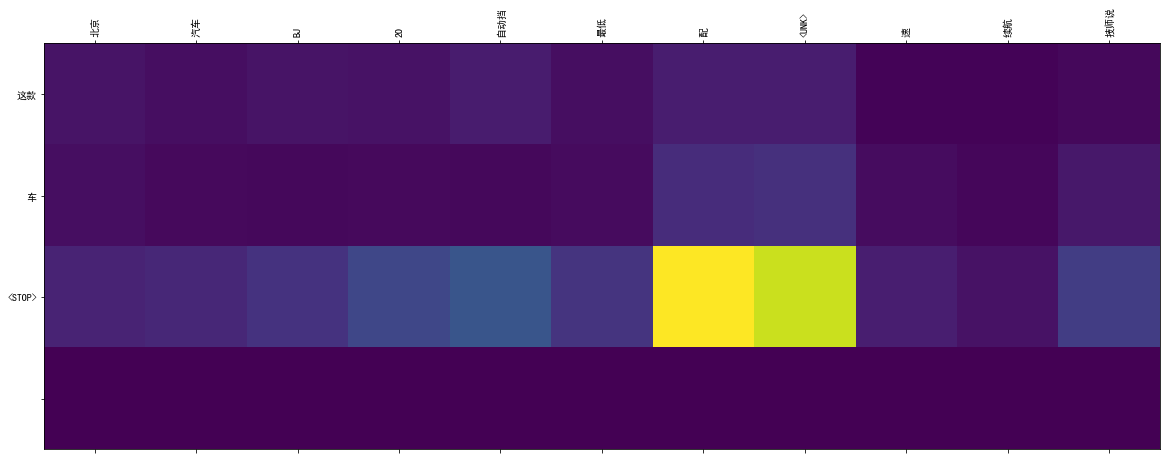

In [104]:
translate(sentence)

# 批量预测

In [85]:
def batch_predict(inps):
    # 判断输入长度
    batch_size=len(inps)
    # 开辟结果存储list
    preidicts=[''] * batch_size
    
    inps = tf.convert_to_tensor(inps)
    # 0. 初始化隐藏层输入
    hidden = [tf.zeros((batch_size, units))]
    # 1. 构建encoder
    enc_output, enc_hidden = model.encoder(inps, hidden)
    # 2. 复制
    dec_hidden = enc_hidden
    # 3. <START> * BATCH_SIZE 
    dec_input = tf.expand_dims([vocab['<START>']] * batch_size, 1)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)
    # Teacher forcing - feeding the target as the next input
    for t in range(max_length_targ): # 输出序列的最大长度
        # 计算上下文
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        # 单步预测
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)
        
        # id转换 贪婪搜索
        predicted_ids = tf.argmax(predictions,axis=1).numpy()
        
        
        for index,predicted_id in enumerate(predicted_ids):
            preidicts[index]+= reverse_vocab[predicted_id] + ' '
        
        # using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)

    results=[]
    for preidict in preidicts:
        # 去掉句子前后空格
        preidict=preidict.strip()
        # 句子小于max len就结束了 截断
        if '<STOP>' in preidict:
            # 截断stop
            preidict=preidict[:preidict.index('<STOP>')]
        # 保存结果
        results.append(preidict)
    return results
# max_tar_len=8
# x x x stop x x x x

In [86]:
from tqdm import tqdm
import math

In [87]:
def model_predict(data_X,batch_size):
    # 存储结果
    results=[]
    # 样本数量
    sample_size=len(data_X)
    # batch 操作轮数 math.ceil向上取整 小数 +1
    # 因为最后一个batch可能不足一个batch size 大小 ,但是依然需要计算  
    steps_epoch = math.ceil(sample_size/batch_size)
    # [0,steps_epoch)
    for i in tqdm(range(steps_epoch)):
        batch_data = data_X[i*batch_size:(i+1)*batch_size]
        results+=batch_predict(batch_data)
    return results

In [88]:
%%time
results=model_predict(test_X,batch_size=64)


 99%|█████████▊| 309/313 [01:48<00:01,  2.81it/s]


100%|██████████| 313/313 [01:50<00:00,  2.84it/s]

CPU times: user 1min 46s, sys: 6.67 s, total: 1min 53s
Wall time: 1min 50s


In [89]:
results[1005]

'， 描述 ， 没有 问题 ， 需要 四 s 店 进行 清洗 '

In [91]:
# 读入提交数据
test_df=pd.read_csv(test_data_path)
test_df.head()

,QID,Brand,Model,Question,Dialogue
0,Q1,大众(进口),高尔夫(进口),我的帕萨特烧机油怎么办怎么办？,技师说：你好，请问你的车跑了多少公里了，如果在保修期内，可以到当地的4店里面进行检查维修。如...
1,Q2,一汽-大众奥迪,奥迪A6,修一下多少钱是换还是修,技师说：你好师傅！抛光处理一下就好了！50元左右就好了，希望能够帮到你！祝你生活愉快！
2,Q3,上汽大众,帕萨特,帕萨特领域 喇叭坏了 店里说方向盘里线坏了 换一根两三百不等 感觉太贵,技师说：你好，气囊油丝坏了吗，这个价格不贵。可以更换。
3,Q4,南京菲亚特,派力奥,发动机漏气会有什么征兆？,技师说：你好！一：发动机没力，并伴有“啪啪”的漏气声音。二：发动机没力，并伴有排气管冒黑烟。...
4,Q5,东风本田,思铂睿,请问 那天右后胎扎了订，补了胎后跑高速80多开始有点抖，110时速以上抖动明显，以为是未做动...,技师说：你好师傅！可能前轮平衡快脱落或者不平衡造成的！建议前轮做一下动平衡就好了！希望能够帮...


In [92]:
def submit_proc(sentence):
    sentence=sentence.lstrip(' ，！。')
    sentence=sentence.replace(' ','')
    if sentence=='':
        sentence='随时联系'
    return sentence

# 判断是否有空值

In [93]:
for idx,result in enumerate(results):
    if result=='':print(idx)

In [94]:
# 赋值结果
test_df['Prediction']=results
#　提取ID和预测结果两列
test_df=test_df[['QID','Prediction']]

In [95]:
test_df.head()

,QID,Prediction
0,Q1,， 现在 行驶 一千公里 ， 保修期 内 ， 4s店 内 4s店 进行 维修 ， 检查 机油...
1,Q2,！ 描述 ， 没有 等到 回复 ， 需要 300 元 左右 ！
2,Q3,， 描述 情况 分析 事故 车 ， 价格 不 贵 。
3,Q4,分析 诊断 电脑 读取 发动机 缸 垫 。
4,Q5,， 描述 ， 这种 情况 ， 轮胎 问题 ， 轮胎 问题 ， 轮胎 问题 ， 轮胎 问题 ，...


# 结果处理

In [96]:
# 判断是否有空值
# for predic in test_df['Prediction']:
#     if type(predic) != str:
#         print(predic)

In [97]:
test_df['Prediction']=test_df['Prediction'].apply(submit_proc)

In [98]:
test_df.head()

,QID,Prediction
0,Q1,现在行驶一千公里，保修期内，4s店内4s店进行维修，检查机油消耗过大，更换机油消耗过大，检查...
1,Q2,描述，没有等到回复，需要300元左右！
2,Q3,描述情况分析事故车，价格不贵。
3,Q4,分析诊断电脑读取发动机缸垫。
4,Q5,描述，这种情况，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问...


# 保存结果

In [99]:
from utils.file_utils import get_result_filename

In [106]:
# 获取结果存储路径
result_save_path = get_result_filename(params["batch_size"],params["epochs"] , params["max_enc_len"], params["embedding_dim"],commit='_4_1_submit_proc_add_masks_loss_seq2seq_code')

In [108]:
# 保存结果.
test_df.to_csv(result_save_path,index=None,sep=',')

In [109]:
result_save_path

'/home/roger/kaikeba/03_lecture/code/result/2019_12_08_22_30_23_batch_size_64_epochs_5_max_length_inp_200_embedding_dim_500_4_1_submit_proc_add_masks_loss_seq2seq_code.csv'

In [110]:
# 读取结果
test_df=pd.read_csv(result_save_path)
# 查看格式
test_df.head(10)

,QID,Prediction
0,Q1,现在行驶一千公里，保修期内，4s店内4s店进行维修，检查机油消耗过大，更换机油消耗过大，检查...
1,Q2,描述，没有等到回复，需要300元左右！
2,Q3,描述情况分析事故车，价格不贵。
3,Q4,分析诊断电脑读取发动机缸垫。
4,Q5,描述，这种情况，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问题，轮胎问...
5,Q6,描述，这种情况，描述，这种情况，描述，这种情况，描述，这种情况，描述，这种情况，描述，这种情...
6,Q7,添加，添加防冻液，添加防冻液，添加防冻液，添加防冻液，添加防冻液，添加防冻液，添加防冻液，添...
7,Q8,机油灯亮，需要使用5w30机油，需要检查机油灯亮，需要使用5w30机油，需要检查机油灯亮，需...
8,Q9,图片来看，轮胎磨损严重，这种情况，轮胎磨损严重，这种情况，轮胎磨损严重，这种情况，轮胎磨损严...
9,Q10,这种情况可能天气凉情况下，长时间停放时间长以后，时间长以后，时间长以后，时间长以后，时间长以...
